# Setup

In [1]:
%matplotlib notebook
LOG_PLOT = True

## Imports

In [2]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import pandas as pd
from datetime import datetime

import requests
from json import loads, dumps

import os

## ECDC Data

In [3]:

# WORLD
def fetch_world():
    response = requests.get('https://opendata.ecdc.europa.eu/covid19/casedistribution/json')    
    json = response.json()
    df = pd.read_json(dumps(json['records']))   
    df['dateRep']=pd.to_datetime(df['dateRep'].astype(str), format='%d/%m/%Y')

    return df



def plot_country(geoId, roll_days=7, log=False):
    selection = df[df.geoId==geoId].sort_values(by=['year','month','day'], ascending=True)

    f,ax = plt.subplots()
    ax.plot(selection.dateRep, selection['cases'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
#     ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    ax.bar(selection.dateRep, selection['cases'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    if log:
        plt.yscale('log')
        
    plt.title(selection.iloc[0].countriesAndTerritories.replace('_', ' '))
    plt.tight_layout()

    return f



df = fetch_world()


## Austria - from Gesundheitsminesterium

In [4]:
# AUSTRIA
WEEKDAYS = ('Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday')

def fetch_Austria():
    df = pd.read_csv('https://info.gesundheitsministerium.at/data/Epikurve.csv', delimiter=';')
    weekday= []
    print(df.columns)
    for i, row in df.iterrows():
        day_num = datetime.strptime(row['time'], '%d.%m.%Y').weekday()
        weekday.append(day_num)
        
    df['weekday'] = weekday
    df['time']=pd.to_datetime(df['time'].astype(str), format='%d.%m.%Y')
#     .dt.strftime('%d/%m/%Y')

    return df

def plot_Austria(roll_days=7, log=False):
    df = fetch_Austria()
    f,ax = plt.subplots()
    ax.plot(df.time, df['tägliche Erkrankungen'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    ax.bar(df.time, df['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    plt.title('Positive COVID tests')
    if log:
        plt.yscale('log')
    plt.tight_layout()
    return f

df_at  = fetch_Austria()


Index(['time', 'tägliche Erkrankungen', 'Timestamp'], dtype='object')


## Aggregation Functions

In [5]:
import numpy as np
def rolling_avg(x):
    return np.round(x.iloc[-7:].mean())

def latest(x):
    return x.iloc[-1]

def last_7_days_sum(x):
    return x.iloc[-7:].sum()
    

## DF Subsets

In [6]:
SELECTION =  df[df.geoId.isin(['AT', 'IN', 'US', 'UK', 'DE', 'IT', 'NL'])]
EU = df[df.continentExp=='Europe']
AMERICA = df[(df.continentExp=='America')]


# Overview

## Selected Countries

In [7]:
SELECTION.sort_values(
    by=['year','month','day'], ascending=True).groupby("countriesAndTerritories").agg(
    {'cases': ['sum', last_7_days_sum, latest, rolling_avg, 'max' ],
    'deaths': ['sum',  last_7_days_sum, latest, rolling_avg, 'max' ],} ).sort_values(by= ('cases','last_7_days_sum'),ascending=False)

cases                                            \
                              sum last_7_days_sum latest rolling_avg    max   
countriesAndTerritories                                                       
India                     5732518          614265  86508       87752  97894   
United_States_of_America  6934204          303313  37930       43330  78427   
United_Kingdom             409729           31510   6178        4501   6178   
Netherlands                100493           14256   2351        2037   2351   
Germany                    278070           12213   2143        1745   6294   
Italy                      302537           11095   1640        1585   6557   
Austria                     40558            5110    661         730   1141   

                          deaths                                           
                             sum last_7_days_sum latest rolling_avg   max  
countriesAndTerritories                                                    
India                      91149            7951   1129        1136  2003  
United_States_of_America  201909            5107   1102         730  4928  
United_Kingdom             41862             178     37          25  1224  
Netherlands                 6287              36      5           5   234  
Germany                     9428              57     19           8   315  
Italy                      35758             113     20          16   971  
Austria                      777              19      6           3    31

## Most cases in the last 7 days

### Europe

In [8]:
EU.sort_values(
    by=['year','month','day'], ascending=True).groupby("countriesAndTerritories").agg(
    {'cases': ['sum', last_7_days_sum, latest, rolling_avg, 'max' ],
    'deaths': ['sum',  last_7_days_sum, latest, rolling_avg, 'max' ],} ).sort_values(by= ('cases','last_7_days_sum'),ascending=False).head(10)

cases                                            \
                             sum last_7_days_sum latest rolling_avg    max   
countriesAndTerritories                                                      
Spain                     693556           79196  11289       11314  31428   
France                    481141           76253  13072       10893  13498   
Russia                   1122241           42722   6431        6103  12640   
United_Kingdom            409729           31510   6178        4501   6178   
Ukraine                   184734           22074   3497        3153   5863   
Czechia                    55464           14432   2306        2062   3123   
Netherlands               100493           14256   2351        2037   2351   
Germany                   278070           12213   2143        1745   6294   
Italy                     302537           11095   1640        1585   6557   
Romania                   116415            9404   1767        1343   1767   

                        deaths                                           
                           sum last_7_days_sum latest rolling_avg   max  
countriesAndTerritories                                                  
Spain                    31034             791    130         113  1179  
France                   31459             414     43          59  2004  
Russia                   19799             882    150         126   312  
United_Kingdom           41862             178     37          25  1224  
Ukraine                   3705             365     63          52   129  
Czechia                    555              73     24          10    24  
Netherlands               6287              36      5           5   234  
Germany                   9428              57     19           8   315  
Italy                    35758             113     20          16   971  
Romania                   4550             265     47          38    60

### America

In [9]:
AMERICA.sort_values(
    by=['year','month','day'], ascending=True).groupby("countriesAndTerritories").agg(
    {'cases': ['sum', last_7_days_sum, latest, rolling_avg, 'max' ],
    'deaths': ['sum',  last_7_days_sum, latest, rolling_avg, 'max' ],} ).sort_values(by= ('cases','last_7_days_sum'),ascending=False).head(10)

cases                                            \
                              sum last_7_days_sum latest rolling_avg    max   
countriesAndTerritories                                                       
United_States_of_America  6934204          303313  37930       43330  78427   
Brazil                    4624885          205802  33281       29400  69074   
Argentina                  664799           87474  12638       12496  17213   
Colombia                   784268           47891   6731        6842  13056   
Peru                       782695           38295   6149        5471  10143   
Mexico                     710049           29118   4786        4160   9556   
Chile                      449903           10616   1380        1517  36179   
Costa_Rica                  68059            8543   1370        1220   1897   
Ecuador                    129892            8367   2249        1195  11536   
Canada                     147753            8006   1090        1144   2760   

                          deaths                                           
                             sum last_7_days_sum latest rolling_avg   max  
countriesAndTerritories                                                    
United_States_of_America  201909            5107   1102         730  4928  
Brazil                    138977            4871    869         696  1595  
Argentina                  14376            2466    424         352   573  
Colombia                   24746            1268    176         181   400  
Peru                       31870             819    284         117  3935  
Mexico                     74949            2971    601         424  1091  
Chile                      12345             287     24          41  1057  
Costa_Rica                   781             132     21          19    39  
Ecuador                    11171             175     45          25  3800  
Canada                      9243              50      9           7   222

### World

In [10]:
df.sort_values(
    by=['year','month','day'], ascending=True).groupby("countriesAndTerritories").agg(
    {'cases': ['sum', last_7_days_sum, latest, rolling_avg, 'max' ],
    'deaths': ['sum',  last_7_days_sum, latest, rolling_avg, 'max' ],} ).sort_values(by= ('cases','last_7_days_sum'),ascending=False).head(10)

cases                                            \
                              sum last_7_days_sum latest rolling_avg    max   
countriesAndTerritories                                                       
India                     5732518          614265  86508       87752  97894   
United_States_of_America  6934204          303313  37930       43330  78427   
Brazil                    4624885          205802  33281       29400  69074   
Argentina                  664799           87474  12638       12496  17213   
Spain                      693556           79196  11289       11314  31428   
France                     481141           76253  13072       10893  13498   
Colombia                   784268           47891   6731        6842  13056   
Russia                    1122241           42722   6431        6103  12640   
Peru                       782695           38295   6149        5471  10143   
Israel                     204690           32922  11316        4703  11316   

                          deaths                                           
                             sum last_7_days_sum latest rolling_avg   max  
countriesAndTerritories                                                    
India                      91149            7951   1129        1136  2003  
United_States_of_America  201909            5107   1102         730  4928  
Brazil                    138977            4871    869         696  1595  
Argentina                  14376            2466    424         352   573  
Spain                      31034             791    130         113  1179  
France                     31459             414     43          59  2004  
Colombia                   24746            1268    176         181   400  
Russia                     19799             882    150         126   312  
Peru                       31870             819    284         117  3935  
Israel                      1325             160     40          23    71

## Lowset number of new cases in the last 7 days

### Europe*

\*among countries with population of at least 1 million

In [11]:
selection = EU[EU.popData2019>1*10**6]
selection.sort_values(
    by=['year','month','day'], ascending=True).groupby("countriesAndTerritories").agg(
    {'cases': ['sum', last_7_days_sum, latest, rolling_avg, 'max' ],
    'deaths': ['sum',  last_7_days_sum, latest, rolling_avg, 'max' ],} ).sort_values(by= ('cases','last_7_days_sum'),ascending=False).tail(10)

cases                                         deaths  \
                           sum last_7_days_sum latest rolling_avg  max    sum   
countriesAndTerritories                                                         
Bulgaria                 19283             893    160         128  330    779   
Azerbaijan               39524             866    146         124  590    580   
Norway                   13152             759    152         108  425    267   
Slovenia                  4694             734    136         105  137    133   
Finland                   9288             538     93          77  267    343   
Lithuania                 3932             490     73          70  122     87   
Serbia                   33080             467     81          67  467    744   
Kosovo                   15270             431     62          62  496    616   
Estonia                   3033             277     57          40  134     64   
Latvia                    1572              86     12          12   71     36   

                                                                
                        last_7_days_sum latest rolling_avg max  
countriesAndTerritories                                         
Bulgaria                             35     12           5  18  
Azerbaijan                           11      2           2  13  
Norway                                2      0           0  13  
Slovenia                              2      0           0   6  
Finland                               4      2           1  43  
Lithuania                             0      0           0   6  
Serbia                                8      1           1  18  
Kosovo                               12      1           2  40  
Estonia                               0      0           0   6  
Latvia                                1      0           0   4

### America*

\*among countries with population of at least 10 million

In [12]:
selection = AMERICA[AMERICA.popData2019>1*10**7]
selection.sort_values(
    by=['year','month','day'], ascending=True).groupby("countriesAndTerritories").agg(
    {'cases': ['sum', last_7_days_sum, latest, rolling_avg, 'max' ],
    'deaths': ['sum',  last_7_days_sum, latest, rolling_avg, 'max' ],} ).sort_values(by= ('cases','last_7_days_sum'),ascending=False).tail(10)

cases                                            \
                            sum last_7_days_sum latest rolling_avg    max   
countriesAndTerritories                                                     
Mexico                   710049           29118   4786        4160   9556   
Chile                    449903           10616   1380        1517  36179   
Ecuador                  129892            8367   2249        1195  11536   
Canada                   147753            8006   1090        1144   2760   
Venezuela                 69439            6023    986         860   2133   
Guatemala                 87442            4518    819         645   4233   
Dominican_Republic       109737            4216    468         602   2147   
Bolivia                  131990            3118    537         445   2687   
Cuba                       5270             394     48          56     93   
Haiti                      8646             105     13          15    284   

                        deaths                                           
                           sum last_7_days_sum latest rolling_avg   max  
countriesAndTerritories                                                  
Mexico                   74949            2971    601         424  1091  
Chile                    12345             287     24          41  1057  
Ecuador                  11171             175     45          25  3800  
Canada                    9243              50      9           7   222  
Venezuela                  574              63     10           9    17  
Guatemala                 3154             145     17          21    74  
Dominican_Republic        2074              65     10           9    39  
Bolivia                   7731             253     38          36  1610  
Cuba                       118               9      1           1     6  
Haiti                      225               5      2           1    12

### World*
\*among countries with population of at least 10 million

In [13]:
selection = df[df.popData2019>1*10**7]
selection.sort_values(
    by=['year','month','day'], ascending=True).groupby("countriesAndTerritories").agg(
    {'cases': ['sum', last_7_days_sum, latest, rolling_avg, 'max' ],
    'deaths': ['sum',  last_7_days_sum, latest, rolling_avg, 'max' ],} ).sort_values(by= ('cases','last_7_days_sum'),ascending=False).tail(10)

cases                                          \
                               sum last_7_days_sum latest rolling_avg  max   
countriesAndTerritories                                                      
Malawi                        5746              45      9           6  192   
Sudan                        13578              43      0           6  520   
Thailand                      3516              26      2           4  263   
Niger                         1193              13      0           2   69   
Yemen                         2032              12      0           2  116   
Vietnam                       1069               6      1           1   50   
Taiwan                         509               6      0           1   31   
Burundi                        476               4      2           1   40   
United_Republic_of_Tanzania    509               0      0           0  174   
Cambodia                       275               0      0           0   35   

                            deaths                                         
                               sum last_7_days_sum latest rolling_avg max  
countriesAndTerritories                                                    
Malawi                         179               1      0           0  12  
Sudan                          836               0      0           0  38  
Thailand                        59               1      0           0   4  
Niger                           69               0      0           0   5  
Yemen                          587               3      0           0  52  
Vietnam                         35               0      0           0   4  
Taiwan                           7               0      0           0   3  
Burundi                          1               0      0           0   1  
United_Republic_of_Tanzania     21               0      0           0   6  
Cambodia                         0               0      0           0   0

# Austria
Compare ECDC data with Gesundheitsminesterium Data

### Total number of cases

In [14]:
df_at['tägliche Erkrankungen'].sum(), df[df.geoId=='AT'].cases.sum()

(40865, 40558)

## Gesundheitsministerium vs. ECDC (Discrepancy!)

<IPython.core.display.Javascript object>


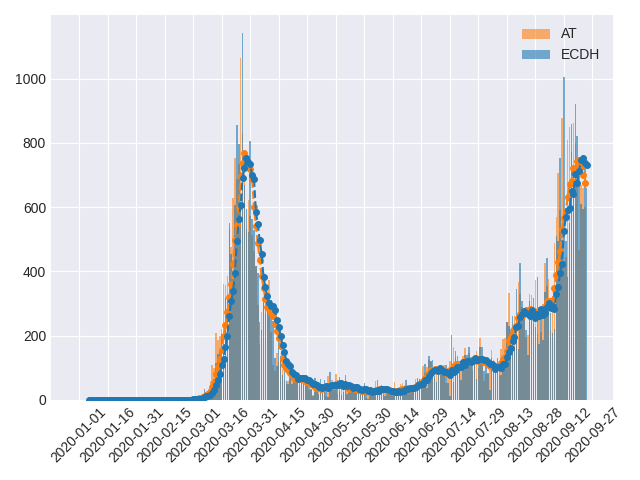

In [15]:
f,ax = plt.subplots()
# ax.bar(df_at.time, df_at['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')

ax.plot(df_at.time, df_at['tägliche Erkrankungen'].rolling(7).mean(),  marker='o', markersize=4, linestyle='--', color='C1')

ax.bar(df_at.time, df_at['tägliche Erkrankungen'],label='AT',  alpha=0.6, color='C1')
selection = df[df.geoId=='AT'].sort_values(by=['year','month','day'], ascending=True)
ax.bar(selection.dateRep, selection['cases'],label='ECDH',  alpha=0.6, color='C0')
ax.plot(selection.dateRep, selection['cases'].rolling(7).mean(), marker='o', markersize=4, linestyle='--',color='C0')
# plt.yscale('log')

ax.xaxis.set_major_locator(plt.MaxNLocator(20));

plt.xticks(rotation=45);
plt.legend(loc='best')
plt.tight_layout()



### Weekday bias

<IPython.core.display.Javascript object>


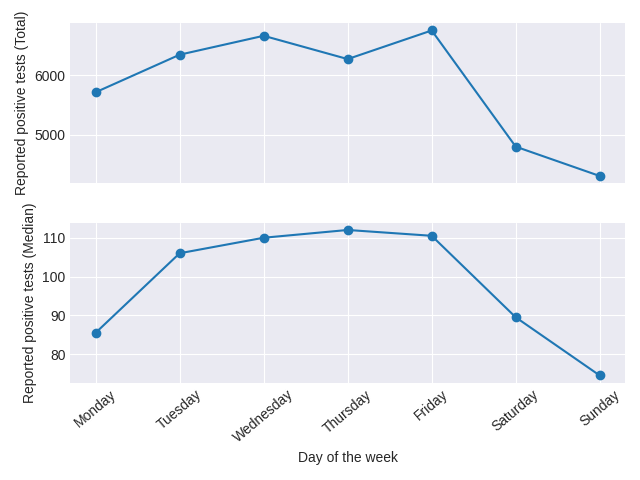

In [16]:
f, ax = plt.subplots(nrows=2, sharex=True)
df_at.groupby(['weekday']).sum()['tägliche Erkrankungen'].plot(ax=ax[0], marker='o')
ax[0].set_ylabel('Reported positive tests (Total)')
df_at.groupby(['weekday']).median()['tägliche Erkrankungen'].plot(ax=ax[1], marker='o')
ax[1].set_ylabel('Reported positive tests (Median)')
ax[1].set_xlabel('Day of the week')
ax[1].set_xticks([0,1,2,3,4,5,6])
ax[1].set_xticklabels(WEEKDAYS, rotation=40)
plt.tight_layout()

# India

<IPython.core.display.Javascript object>


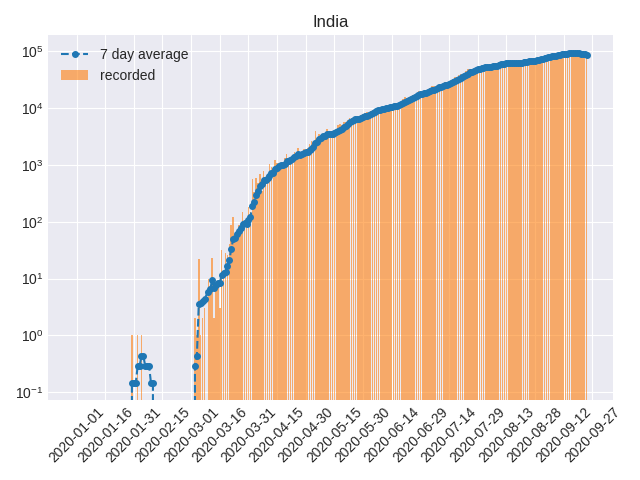

In [17]:
plot_country('IN', log=LOG_PLOT);

# USA

<IPython.core.display.Javascript object>


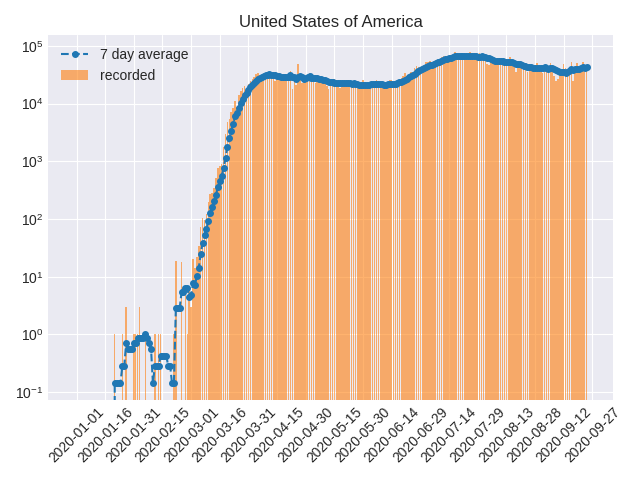

In [18]:
plot_country('US', log=LOG_PLOT);


# Germany

<IPython.core.display.Javascript object>


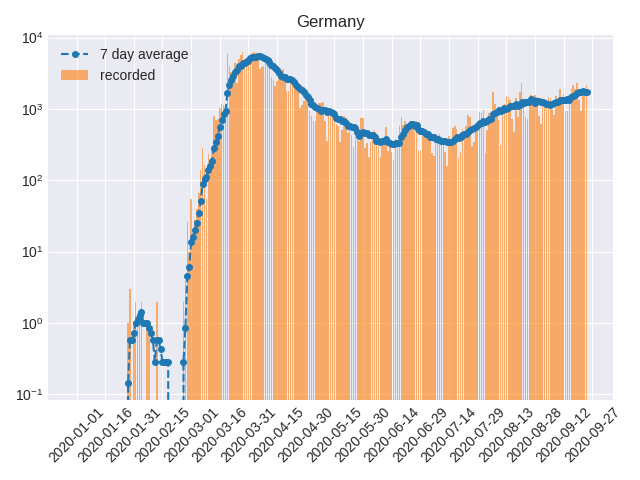

In [19]:
plot_country('DE', log=LOG_PLOT);

## UK

<IPython.core.display.Javascript object>


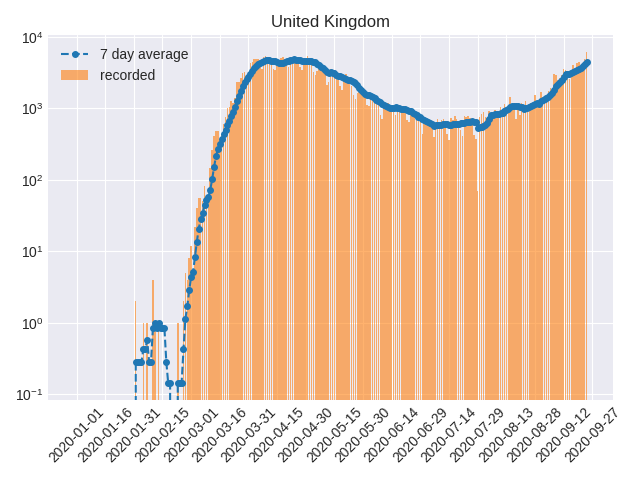

In [20]:
plot_country('UK', log=LOG_PLOT);

# China

<IPython.core.display.Javascript object>


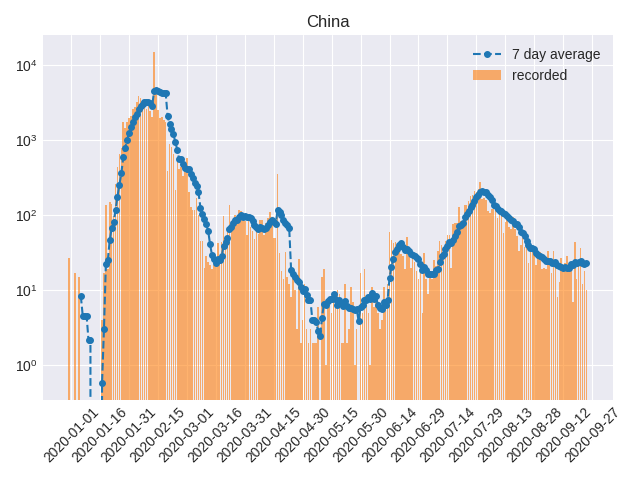

In [21]:
plot_country('CN', log=LOG_PLOT);


# Commit and Push

In [22]:
%cd Documents/code/covid19/
now = datetime.now()
commit_message = "Last run on " + now.strftime('%Y-%m-%d %H:%M')
commit_message
! echo $commit_message > commit_message.txt
! git add .
! git commit -F commit_message.txt
! git push


[Errno 2] No such file or directory: 'Documents/code/covid19/'
/home/gythaogg/Documents/code/covid19/notebooks
On branch develop
Your branch is up-to-date with 'origin/develop'.

nothing to commit, working tree clean
Everything up-to-date
